# 2024-026 Differential Peak Analysis

This notebook describes steps to perform differential peak analysis of ATAC-seq data.

## Initialize Enviroment

In [1]:
# Load Libraries
library(DESeq2)
library(ggplot2)
library(dplyr)
library(tidyr)

# Load data
exp_dir     <- "/home/dalbao/2024-026-Tcf7ATAC"
nfcore_dir  <- "01_nfcore_241228"
nb_dir      <- "02_bp_notebooks"
prefix      <- "DA-DAPS_reduced"                                   # bp for broad peak calling settings

# Experiments to analyze
exp <- c("DA")

# Comparisons
comp_file <- "metadata/comparisons_da_naive.csv"

# Annotations
anno_file <- "250113-bp-peakAnno-Filtered.csv"
# Add folder structure to anno_file
anno_file <- paste(nfcore_dir, anno_file, sep = "/")

# Filter file
filter_file <- "241231-bp-peakFilter.txt"
# Add folder structure to filter_file
filter_file <- paste(nfcore_dir, filter_file, sep = "/")

# nf-core ATAC-seq pipeline calls peaks from two different libraries:
library     <- "merged_library"
# If library == merged_library, lib_sh is mLb
# else if it is == merged_replicates, lib_sh is mRp
lib_sh      <- ifelse(library == "merged_library", "mLb", "mRp")

# nf-core ATAC-seq pipeline calls peaks in two types, broad_peak and narrow_peak:
peak_type   <- "broad_peak"
# If peak_type == broad_peak, peak_sh is bp
peak_sh     <- ifelse(peak_type == "broad_peak", "bp", "np")

# Add peak type and date to prefix
prefix <- paste0(format(Sys.Date(), "%y%m%d"), "-", peak_sh, "-", prefix)

# Move to working directory
setwd(exp_dir)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb



In [2]:
# Find featre counts file
featureCounts <- paste( nfcore_dir,
                        "/bwa/",
                        library,
                        "/macs2/",
                        peak_type,
                        "/consensus/",
                        "consensus_peaks.", lib_sh, ".clN.featureCounts.txt", sep = "")

# Load feature counts
featureCounts <- read.table(featureCounts,
                            header = TRUE)

# Remove unnecessary columns
featureCounts <- featureCounts[, -c(2:6)]

# Rename columns
sample_suffix <- paste0(".", lib_sh, ".clN.sorted.bam")
colnames(featureCounts) <- gsub(sample_suffix, "", colnames(featureCounts))

# Make intervals as row names
rownames(featureCounts) <- featureCounts$Geneid
featureCounts <- featureCounts[, -1]

# Check
head(featureCounts)

,DW_WT_24h_REP2,DW_RUNX3KO_0h_REP2,DW_WT_12h_REP2,Tcm_WT_REP1,DW_RUNX3KO_2h_REP2,DW_RUNX3KO_6h_REP2,Effector_REP2,DW_RUNX3KO_6h_REP1,DW_RUNX3KO_0h_REP1,DW_WT_0h_REP1,⋯,GFPneg_d28_REP3,GFPneg_d28_REP1,GFPpos_d8_REP1,GFPneg_d8_REP3,GFPpos_d8_REP2,GFPneg_d8_REP2,GFPneg_d28_REP2,GFPpos_d28_REP1,GFPneg_d8_REP1,DW_WT_6h_REP2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Interval_1,2,0,2,0,2,1,2,0,2,1,⋯,5,4,5,4,6,3,2,4,7,7
Interval_2,2,1,10,0,0,2,2,1,2,3,⋯,8,2,5,6,10,7,9,5,7,15
Interval_3,1,1,1,0,3,1,1,0,1,2,⋯,3,2,2,2,2,1,2,5,3,5
Interval_4,1,1,2,0,0,0,0,0,0,0,⋯,4,1,4,1,3,4,1,8,0,3
Interval_5,2,1,0,0,1,2,0,0,0,1,⋯,5,4,5,4,6,1,6,7,6,6
Interval_6,3,3,1,0,1,1,0,0,5,2,⋯,10,2,2,5,0,4,3,8,5,8


In [3]:
# Load sample metadata
sampleMetadata <- read.csv("metadata/sampleMetadata.csv")

# Make sample names as row names
rownames(sampleMetadata) <- sampleMetadata$Sample
sampleMetadata <- sampleMetadata[, -1]

# Check
head(sampleMetadata)

# Make sure the observations in sampleMetadata are in the same order as the columns in featureCounts
sampleMetadata <- sampleMetadata[colnames(featureCounts), ]

# Load keep peaks file
keep <- read.table(filter_file, header = TRUE)
keep <- keep[keep$keep == TRUE, ]

# Keep only features (identified by rowname) that are in keep$interval_id
featureCounts <- featureCounts[rownames(featureCounts) %in% keep$interval_id, ]
head(featureCounts)

,Experiment,Condition,Phenotype,Transduction,Rep,DW_time,DW_genotype,Time,Genotype,Batch
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>
DW_WT_24h_REP2,DW,DW_WT_24h,,,REP2,24,WT,NA,,
DW_RUNX3KO_0h_REP2,DW,DW_RUNX3KO_0h,,,REP2,0,RUNX3KO,NA,,
DW_RUNX3KO_6h_REP1,DW,DW_RUNX3KO_6h,,,REP1,6,RUNX3KO,NA,,
DW_WT_6h_REP1,DW,DW_WT_6h,,,REP1,6,WT,NA,,
CX3CR1pos_shRunx3_REP2,DA,CX3CR1pos_shRunx3,CX3CR1pos,shRunx3,,NA,,NA,,B
DW_WT_0h_REP1,DW,DW_WT_0h,,,REP1,0,WT,NA,,


,DW_WT_24h_REP2,DW_RUNX3KO_0h_REP2,DW_WT_12h_REP2,Tcm_WT_REP1,DW_RUNX3KO_2h_REP2,DW_RUNX3KO_6h_REP2,Effector_REP2,DW_RUNX3KO_6h_REP1,DW_RUNX3KO_0h_REP1,DW_WT_0h_REP1,⋯,GFPneg_d28_REP3,GFPneg_d28_REP1,GFPpos_d8_REP1,GFPneg_d8_REP3,GFPpos_d8_REP2,GFPneg_d8_REP2,GFPneg_d28_REP2,GFPpos_d28_REP1,GFPneg_d8_REP1,DW_WT_6h_REP2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Interval_98,17,32,33,35,12,14,80,3,27,61,⋯,234,224,212,147,176,165,240,364,177,128
Interval_103,29,5,28,22,8,9,51,1,3,13,⋯,183,160,117,172,132,179,242,157,216,66
Interval_105,22,37,23,5,33,47,27,9,29,20,⋯,146,133,81,66,80,97,139,117,95,165
Interval_107,12,12,11,4,15,18,26,6,16,19,⋯,82,73,61,49,59,56,86,73,80,131
Interval_108,108,224,160,110,222,194,174,39,247,244,⋯,858,707,482,449,536,594,751,676,531,975
Interval_110,172,210,274,158,274,271,158,57,264,252,⋯,942,771,527,495,480,648,909,740,633,1388


## Perform Naive Analysis

In [4]:
# DA experiment is tagged as DA in sampleMetadata
daMeta <- sampleMetadata[sampleMetadata$Experiment %in% exp, ]
daExp  <- featureCounts[, colnames(featureCounts) %in% rownames(daMeta), ]

# Check one-to-one correspondence
all(rownames(daMeta) == colnames(daExp))

# Check
head(daMeta)
head(daExp)

[1] TRUE

,Experiment,Condition,Phenotype,Transduction,Rep,DW_time,DW_genotype,Time,Genotype,Batch
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>
CX3CR1pos_shCD19_REP2,DA,CX3CR1pos_shCD19,CX3CR1pos,shCD19,,NA,,NA,,B
CX3CR1pos_shRunx3_REP2,DA,CX3CR1pos_shRunx3,CX3CR1pos,shRunx3,,NA,,NA,,B
GFPpos_shCD19_REP2,DA,GFPpos_shCD19,GFPpos,shCD19,,NA,,NA,,B
CX3CR1pos_shRunx3_REP1,DA,CX3CR1pos_shRunx3,CX3CR1pos,shRunx3,,NA,,NA,,A
GFPneg_shCD19_REP1,DA,GFPneg_shCD19,GFPneg,shCD19,,NA,,NA,,A
GFPpos_shCD19_REP1,DA,GFPpos_shCD19,GFPpos,shCD19,,NA,,NA,,A


,CX3CR1pos_shCD19_REP2,CX3CR1pos_shRunx3_REP2,GFPpos_shCD19_REP2,CX3CR1pos_shRunx3_REP1,GFPneg_shCD19_REP1,GFPpos_shCD19_REP1,GFPpos_shRunx3_REP1,GFPneg_shRunx3_REP2,GFPneg_shRunx3_REP1,naive_REP2,naive_REP1,GFPneg_shCD19_REP2,CX3CR1pos_shCD19_REP1,GFPpos_shRunx3_REP2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Interval_98,76,39,54,64,51,34,32,66,44,58,76,95,57,98
Interval_103,77,26,28,89,24,39,28,31,34,13,19,59,77,41
Interval_105,45,8,21,57,21,33,21,29,19,34,34,36,41,37
Interval_107,42,8,25,46,16,34,24,25,25,21,33,42,36,51
Interval_108,374,160,421,531,470,538,478,349,466,479,650,565,550,531
Interval_110,317,119,355,417,335,409,307,284,351,370,516,426,360,412


Create the DESeq2 object:

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

using ntop=500 top features by variance

using ntop=500 top features by variance



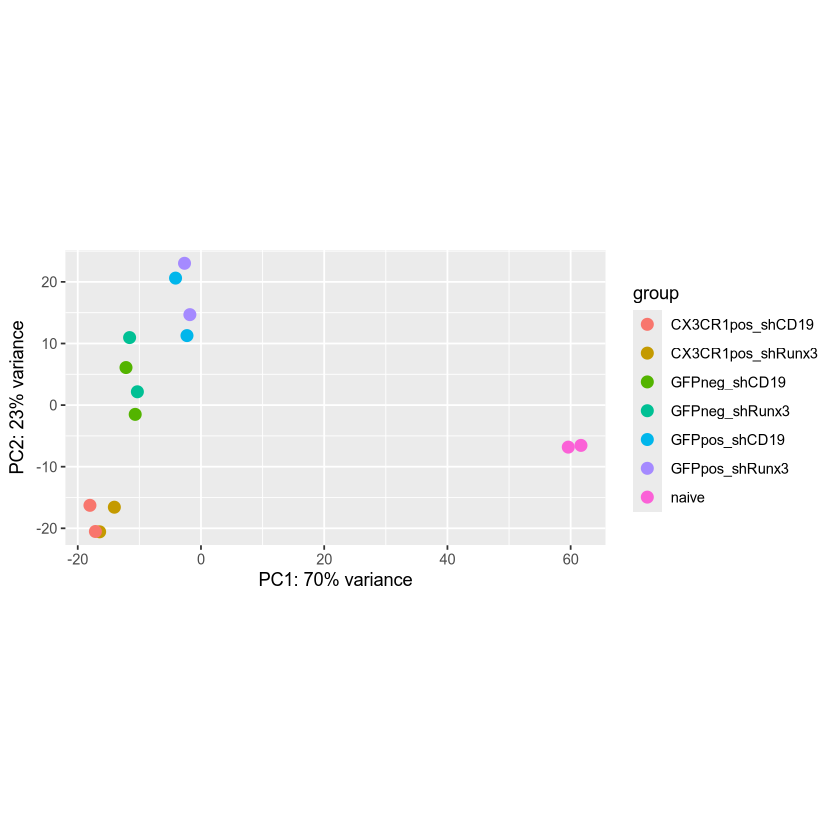

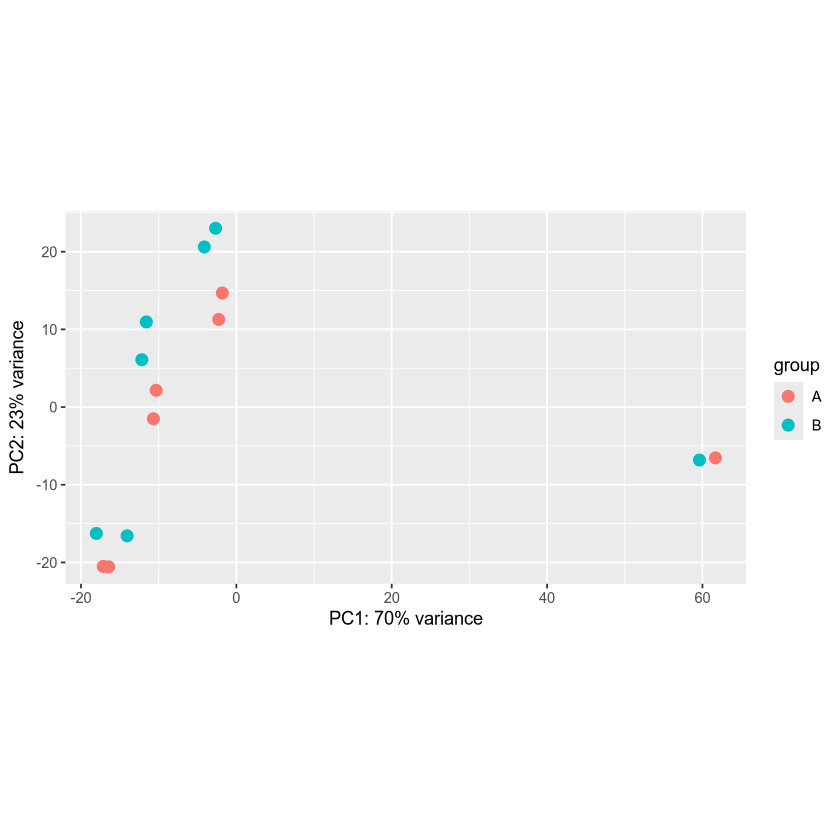

In [5]:
# Create DESeq object
dds <- DESeqDataSetFromMatrix(  countData = daExp,
                                colData   = daMeta,
                                design    = ~ Condition)

# Process DESeq
dds <- DESeq(dds)

# Plot PCA
vst_data <- vst(dds, blind = TRUE)
plotPCA(vst_data, intgroup = c("Condition"))
plotPCA(vst_data, intgroup = c("Batch"))

### Comparisons

In [6]:
# Load comparisons CSV
comparisons <- read.csv(comp_file)

# Initialize an empty list to store results dataframes
results <- list()

# Loop over each row in the comparisons dataframe to perform differential expression analysis
for ( i in 1:nrow(comparisons) ) {
  # Perform differential expression analysis using DESeq2 (or similar) for the current comparison
  # The contrast is set using the 'Condition' column, comparing the numerator vs the denominator
  res <- lfcShrink( dds,
                    contrast = c("Condition", comparisons$Numerator[i], comparisons$Denominator[i]),
                    type = "ashr")
  # The contrast is set using the 'sample' column, comparing the numerator vs the denominator
  stat <- results(dds, contrast = c("Condition", comparisons$Numerator[i], comparisons$Denominator[i]))

  # Create a dataframe from the results object for the current comparison
  # Include comparison identifiers, statistical results, and gene names
  results[[comparisons$Comparison[i]]] <- data.frame(
    comparison = comparisons$Comparison[i],
    numerator = comparisons$Numerator[i],
    denominator = comparisons$Denominator[i],
    name = rownames(res),
    baseMean = res$baseMean,
    log2FC = res$log2FoldChange,
    statistic = stat$stat,
    pvalue = res$pvalue,
    padj = res$padj
  )

  # Remove rows with any missing values to ensure clean data
  results[[comparisons$Comparison[i]]] <- results[[comparisons$Comparison[i]]][complete.cases(results[[comparisons$Comparison[i]]]), ]
  # Order the results by the statistic in decreasing order for prioritization
  results[[comparisons$Comparison[i]]] <- results[[comparisons$Comparison[i]]][order(results[[comparisons$Comparison[i]]]$statistic, decreasing = TRUE), ]

  # Cleanup: Remove temporary variables to free memory (though removing 'i' is not necessary)
  rm(stat, i)
}

# Combine all individual comparison result dataframes into a single dataframe
results_naive <- bind_rows(results)

# View
head(results_naive)

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/

,comparison,numerator,denominator,name,baseMean,log2FC,statistic,pvalue,padj
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,CX3CR1pos_shCD19,CX3CR1pos_shCD19,naive,Interval_229397,833.8780,5.283747,24.25462,5.910468e-130,2.789268e-125
2,CX3CR1pos_shCD19,CX3CR1pos_shCD19,naive,Interval_146480,817.1347,4.516815,22.94733,1.566638e-116,3.696638e-112
3,CX3CR1pos_shCD19,CX3CR1pos_shCD19,naive,Interval_4683,772.1507,5.264215,22.26543,7.994969e-110,1.257662e-105
4,CX3CR1pos_shCD19,CX3CR1pos_shCD19,naive,Interval_259915,776.7800,4.666010,22.13498,1.455804e-108,1.717558e-104
5,CX3CR1pos_shCD19,CX3CR1pos_shCD19,naive,Interval_32210,1150.7031,3.875980,21.83320,1.122838e-105,1.059779e-101
6,CX3CR1pos_shCD19,CX3CR1pos_shCD19,naive,Interval_216889,996.4317,3.412179,21.15965,2.248680e-99,1.768661e-95


## Perform Batch-Corrected Individual Comparisons

[1] TRUE

,Experiment,Condition,Phenotype,Transduction,Rep,DW_time,DW_genotype,Time,Genotype,Batch
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>
CX3CR1pos_shCD19_REP2,DA,CX3CR1pos_shCD19,CX3CR1pos,shCD19,,NA,,NA,,B
CX3CR1pos_shRunx3_REP2,DA,CX3CR1pos_shRunx3,CX3CR1pos,shRunx3,,NA,,NA,,B
GFPpos_shCD19_REP2,DA,GFPpos_shCD19,GFPpos,shCD19,,NA,,NA,,B
CX3CR1pos_shRunx3_REP1,DA,CX3CR1pos_shRunx3,CX3CR1pos,shRunx3,,NA,,NA,,A
GFPneg_shCD19_REP1,DA,GFPneg_shCD19,GFPneg,shCD19,,NA,,NA,,A
GFPpos_shCD19_REP1,DA,GFPpos_shCD19,GFPpos,shCD19,,NA,,NA,,A


,CX3CR1pos_shCD19_REP2,CX3CR1pos_shRunx3_REP2,GFPpos_shCD19_REP2,CX3CR1pos_shRunx3_REP1,GFPneg_shCD19_REP1,GFPpos_shCD19_REP1,GFPpos_shRunx3_REP1,GFPneg_shRunx3_REP2,GFPneg_shRunx3_REP1,GFPneg_shCD19_REP2,CX3CR1pos_shCD19_REP1,GFPpos_shRunx3_REP2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Interval_98,76,39,54,64,51,34,32,66,44,95,57,98
Interval_103,77,26,28,89,24,39,28,31,34,59,77,41
Interval_105,45,8,21,57,21,33,21,29,19,36,41,37
Interval_107,42,8,25,46,16,34,24,25,25,42,36,51
Interval_108,374,160,421,531,470,538,478,349,466,565,550,531
Interval_110,317,119,355,417,335,409,307,284,351,426,360,412


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

using ntop=500 top features by variance

using ntop=500 top features by variance



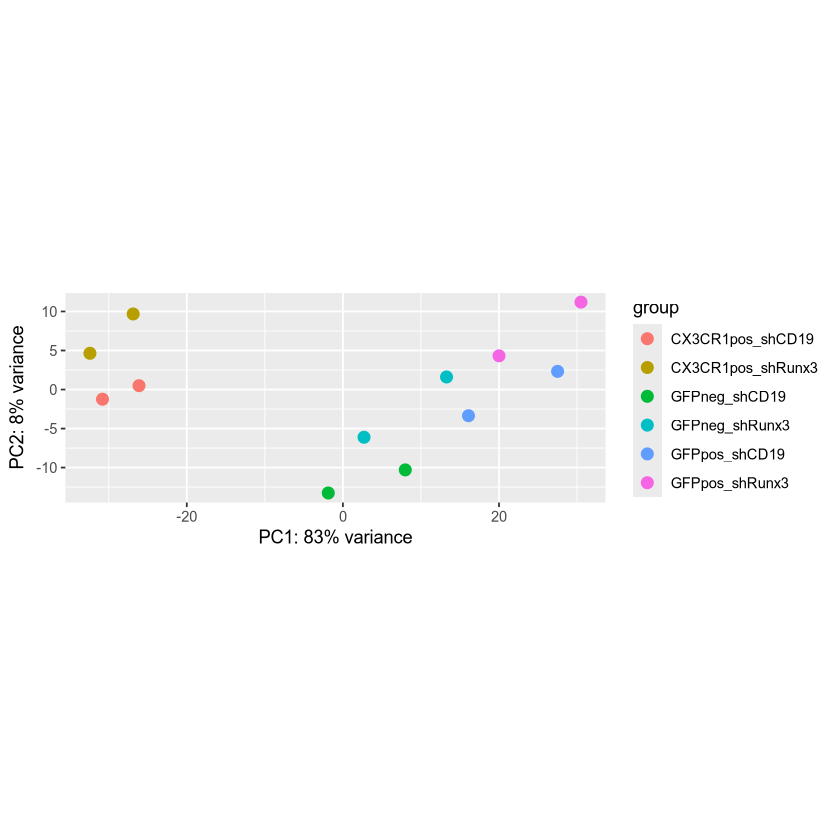

,Denominator,Numerator,Comparison
,<chr>,<chr>,<chr>
1,CX3CR1pos_shCD19,CX3CR1pos_shRunx3,CX3CR1pos_shRunx3_vs_shCD19
2,GFPpos_shCD19,GFPpos_shRunx3,GFPpos_shRunx3_vs_shCD19
3,GFPneg_shCD19,GFPneg_shRunx3,GFPneg_shRunx3_vs_shCD19
4,GFPpos_shCD19,CX3CR1pos_shCD19,shCD19_CX3CR1pos_vs_GFPpos
5,GFPpos_shCD19,GFPneg_shCD19,shCD19_GFPneg_vs_GFPpos
6,GFPneg_shCD19,CX3CR1pos_shCD19,shCD19_CX3CR1pos_vs_GFPneg


using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/

,comparison,numerator,denominator,name,baseMean,log2FC,statistic,pvalue,padj
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,CX3CR1pos_shRunx3_vs_shCD19,CX3CR1pos_shRunx3,CX3CR1pos_shCD19,Interval_268847,170.35350,1.824076,8.228645,1.893428e-16,1.708062e-12
2,CX3CR1pos_shRunx3_vs_shCD19,CX3CR1pos_shRunx3,CX3CR1pos_shCD19,Interval_117508,298.40709,1.438133,7.997417,1.270568e-15,6.877075e-12
3,CX3CR1pos_shRunx3_vs_shCD19,CX3CR1pos_shRunx3,CX3CR1pos_shCD19,Interval_102482,345.70926,1.215187,7.925479,2.272680e-15,1.025093e-11
4,CX3CR1pos_shRunx3_vs_shCD19,CX3CR1pos_shRunx3,CX3CR1pos_shCD19,Interval_250196,77.23263,2.072500,7.864181,3.715190e-15,1.256802e-11
5,CX3CR1pos_shRunx3_vs_shCD19,CX3CR1pos_shRunx3,CX3CR1pos_shCD19,Interval_214810,118.91339,1.620345,7.713749,1.221749e-14,3.673799e-11
6,CX3CR1pos_shRunx3_vs_shCD19,CX3CR1pos_shRunx3,CX3CR1pos_shCD19,Interval_250079,467.93524,1.028862,7.248383,4.217760e-13,7.134077e-10


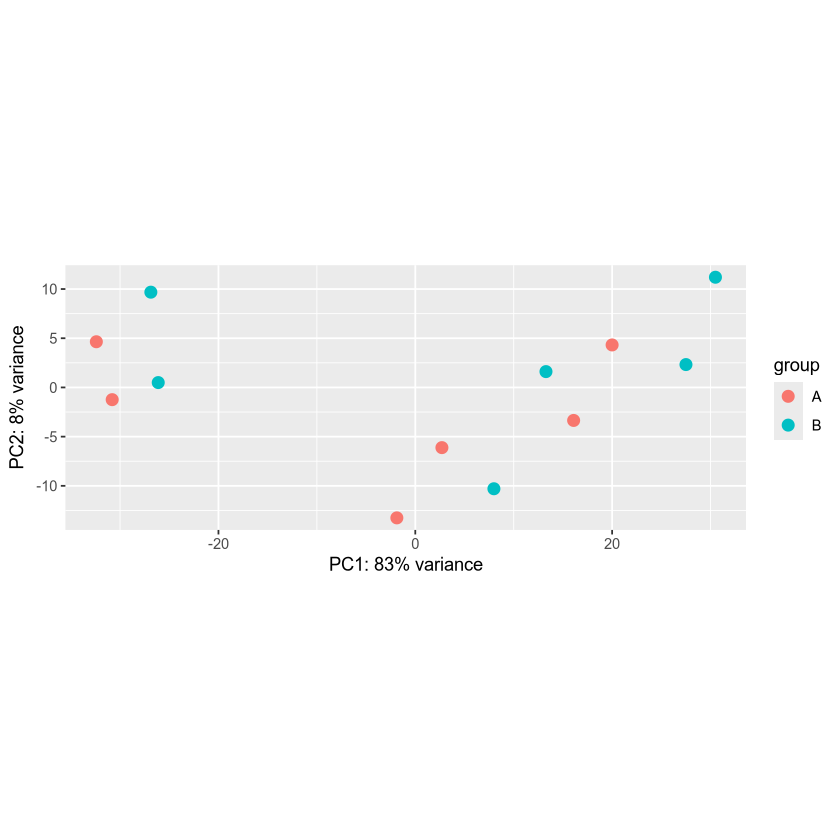

In [7]:
# DA experiment is tagged as DA in sampleMetadata
daMeta <- sampleMetadata[sampleMetadata$Condition != "naive" & sampleMetadata$Experiment == exp[1], ]
daExp  <- featureCounts[, colnames(featureCounts) %in% rownames(daMeta), ]

# Check one-to-one correspondence
all(rownames(daMeta) == colnames(daExp))

# Check
head(daMeta)
head(daExp)

# Create DESeq object
dds <- DESeqDataSetFromMatrix(countData = daExp,
                              colData   = daMeta,
                              design    = ~ Condition + Batch)

# Process DESeq
dds <- DESeq(dds)

# Plot PCA
vst_data <- vst(dds, blind = TRUE)
plotPCA(vst_data, intgroup = c("Condition"))
plotPCA(vst_data, intgroup = c("Batch"))

# Load comparisons CSV
comparisons <- read.csv("metadata/comparisons_da.csv")

head(comparisons)

# Initialize an empty list to store results dataframes
results <- list()

# Loop over each row in the comparisons dataframe to perform differential expression analysis
for ( i in 1:nrow(comparisons) ) {
  # Perform differential expression analysis using DESeq2 (or similar) for the current comparison
  # The contrast is set using the 'Condition' column, comparing the numerator vs the denominator
  res <- lfcShrink( dds,
                    contrast = c("Condition", comparisons$Numerator[i], comparisons$Denominator[i]),
                    type = "ashr")
  # The contrast is set using the 'sample' column, comparing the numerator vs the denominator
  stat <- results(dds, contrast = c("Condition", comparisons$Numerator[i], comparisons$Denominator[i]))

  # Create a dataframe from the results object for the current comparison
  # Include comparison identifiers, statistical results, and gene names
  results[[comparisons$Comparison[i]]] <- data.frame(
    comparison = comparisons$Comparison[i],
    numerator = comparisons$Numerator[i],
    denominator = comparisons$Denominator[i],
    name = rownames(res),
    baseMean = res$baseMean,
    log2FC = res$log2FoldChange,
    statistic = stat$stat,
    pvalue = res$pvalue,
    padj = res$padj
  )

  # Remove rows with any missing values to ensure clean data
  results[[comparisons$Comparison[i]]] <- results[[comparisons$Comparison[i]]][complete.cases(results[[comparisons$Comparison[i]]]), ]
  # Order the results by the statistic in decreasing order for prioritization
  results[[comparisons$Comparison[i]]] <- results[[comparisons$Comparison[i]]][order(results[[comparisons$Comparison[i]]]$statistic, decreasing = TRUE), ]

  # Cleanup: Remove temporary variables to free memory (though removing 'i' is not necessary)
  rm(stat, i)
}

# Combine all individual comparison result dataframes into a single dataframe
results_individual <- bind_rows(results)

# View
head(results_individual)

## Perform Batch-Corrected Combined Comparisons

[1] TRUE

,Experiment,Condition,Phenotype,Transduction,Rep,DW_time,DW_genotype,Time,Genotype,Batch
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>
CX3CR1pos_shCD19_REP2,DA,CX3CR1pos_shCD19,CX3CR1pos,shCD19,,NA,,NA,,B
CX3CR1pos_shRunx3_REP2,DA,CX3CR1pos_shRunx3,CX3CR1pos,shRunx3,,NA,,NA,,B
GFPpos_shCD19_REP2,DA,GFPpos_shCD19,GFPpos,shCD19,,NA,,NA,,B
CX3CR1pos_shRunx3_REP1,DA,CX3CR1pos_shRunx3,CX3CR1pos,shRunx3,,NA,,NA,,A
GFPneg_shCD19_REP1,DA,GFPneg_shCD19,GFPneg,shCD19,,NA,,NA,,A
GFPpos_shCD19_REP1,DA,GFPpos_shCD19,GFPpos,shCD19,,NA,,NA,,A


,CX3CR1pos_shCD19_REP2,CX3CR1pos_shRunx3_REP2,GFPpos_shCD19_REP2,CX3CR1pos_shRunx3_REP1,GFPneg_shCD19_REP1,GFPpos_shCD19_REP1,GFPpos_shRunx3_REP1,GFPneg_shRunx3_REP2,GFPneg_shRunx3_REP1,GFPneg_shCD19_REP2,CX3CR1pos_shCD19_REP1,GFPpos_shRunx3_REP2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Interval_98,76,39,54,64,51,34,32,66,44,95,57,98
Interval_103,77,26,28,89,24,39,28,31,34,59,77,41
Interval_105,45,8,21,57,21,33,21,29,19,36,41,37
Interval_107,42,8,25,46,16,34,24,25,25,42,36,51
Interval_108,374,160,421,531,470,538,478,349,466,565,550,531
Interval_110,317,119,355,417,335,409,307,284,351,426,360,412


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

using ntop=500 top features by variance

using ntop=500 top features by variance



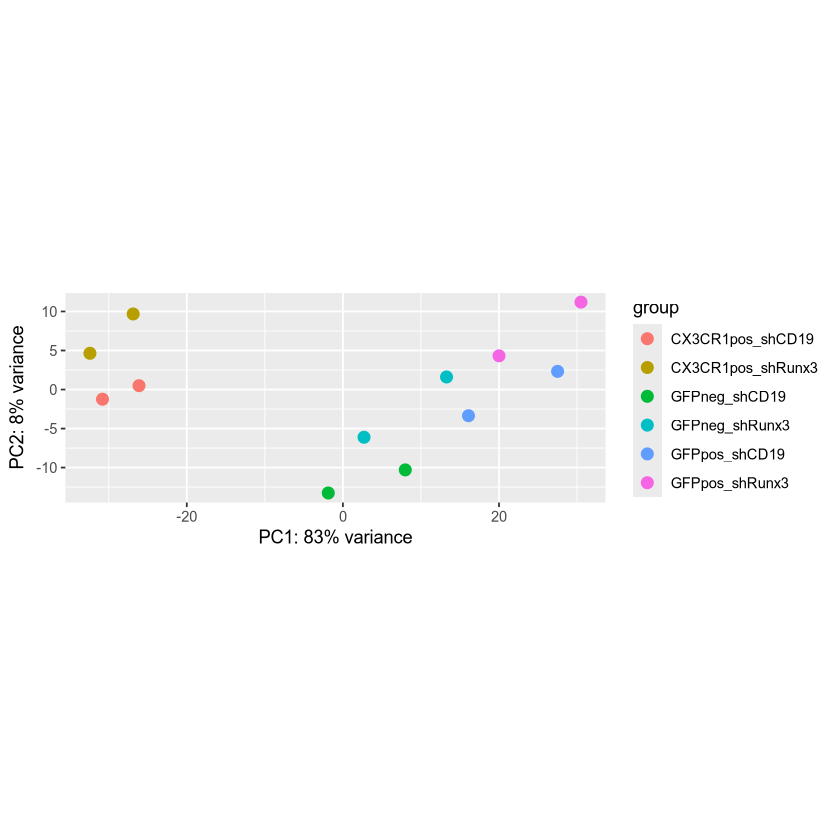

,Denominator,Numerator,Comparison,Coefficient
,<chr>,<chr>,<chr>,<chr>
1,shCD19,shRunx3,shRunx3_vs_shCD19,Transduction
2,GFPpos,GFPneg,GFPneg_vs_GFPpos,Phenotype
3,GFPpos,CX3CR1pos,CX3CR1pos_vs_GFPpos,Phenotype
4,GFPneg,CX3CR1pos,CX3CR1pos_vs_GFPneg,Phenotype


using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041



,comparison,numerator,denominator,name,baseMean,log2FC,statistic,pvalue,padj
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,shRunx3_vs_shCD19,shRunx3,shCD19,Interval_268847,170.35350,1.839108,17.35484,1.813142e-67,8.224774e-63
2,shRunx3_vs_shCD19,shRunx3,shCD19,Interval_214810,118.91339,1.893271,14.71013,5.550449e-49,8.392649e-45
3,shRunx3_vs_shCD19,shRunx3,shCD19,Interval_102482,345.70926,1.251065,14.42315,3.700707e-47,4.196787e-43
4,shRunx3_vs_shCD19,shRunx3,shCD19,Interval_103538,295.33737,1.341354,13.90581,5.840465e-44,5.298703e-40
5,shRunx3_vs_shCD19,shRunx3,shCD19,Interval_263547,80.05694,2.122355,13.54728,8.222230e-42,6.216280e-38
6,shRunx3_vs_shCD19,shRunx3,shCD19,Interval_268785,201.04783,1.828672,13.02397,8.939346e-39,5.068833e-35


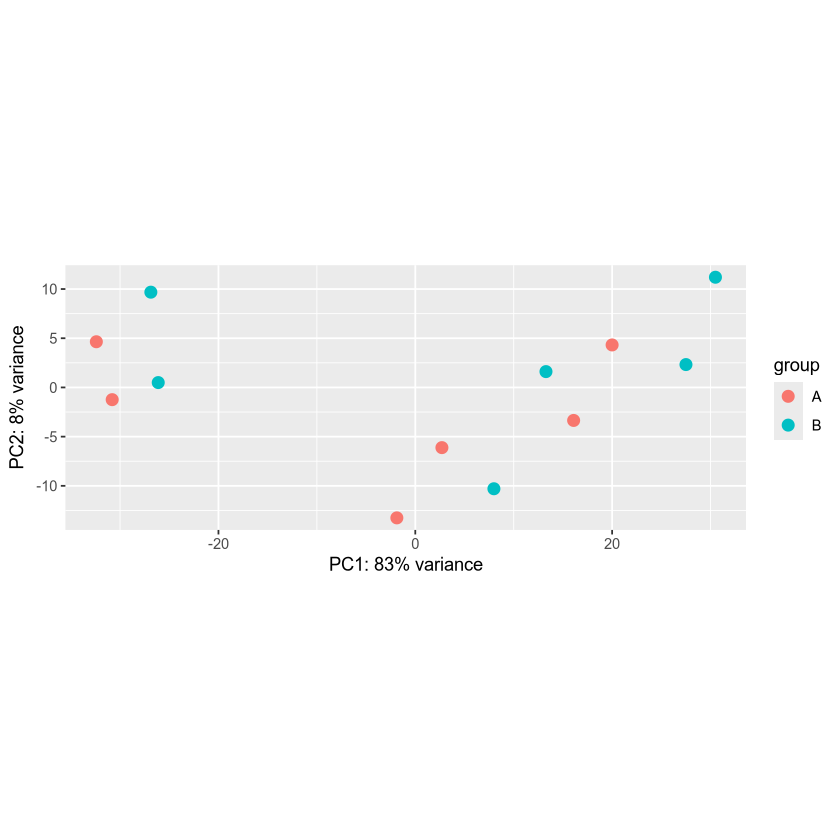

In [8]:
# DA experiment is tagged as DA in sampleMetadata
daMeta <- sampleMetadata[sampleMetadata$Condition != "naive" & sampleMetadata$Experiment == exp[1], ]
daExp  <- featureCounts[, colnames(featureCounts) %in% rownames(daMeta), ]

# Check one-to-one correspondence
all(rownames(daMeta) == colnames(daExp))

# Check
head(daMeta)
head(daExp)

# Create DESeq object
dds <- DESeqDataSetFromMatrix(countData = daExp,
                              colData   = daMeta,
                              design    = ~ Phenotype + Transduction + Batch)

# Process DESeq
dds <- DESeq(dds)

# Plot PCA
vst_data <- vst(dds, blind = TRUE)
plotPCA(vst_data, intgroup = c("Condition"))
plotPCA(vst_data, intgroup = c("Batch"))

# Load comparisons CSV
comparisons <- read.csv("metadata/comparisons_da_combined.csv")

head(comparisons)

# Initialize an empty list to store results dataframes
results <- list()

# Loop over each row in the comparisons dataframe to perform differential expression analysis
for ( i in 1:nrow(comparisons) ) {
  # Perform differential expression analysis using DESeq2 (or similar) for the current comparison
  # The contrast is set using the 'Condition' column, comparing the numerator vs the denominator
  res <- lfcShrink( dds,
                    contrast = c(comparisons$Coefficient[i], comparisons$Numerator[i], comparisons$Denominator[i]),
                    type = "ashr")
  # The contrast is set using the 'sample' column, comparing the numerator vs the denominator
  stat <- results(dds, contrast = c(comparisons$Coefficient[i], comparisons$Numerator[i], comparisons$Denominator[i]))

  # Create a dataframe from the results object for the current comparison
  # Include comparison identifiers, statistical results, and gene names
  results[[comparisons$Comparison[i]]] <- data.frame(
    comparison = comparisons$Comparison[i],
    numerator = comparisons$Numerator[i],
    denominator = comparisons$Denominator[i],
    name = rownames(res),
    baseMean = res$baseMean,
    log2FC = res$log2FoldChange,
    statistic = stat$stat,
    pvalue = res$pvalue,
    padj = res$padj
  )

  # Remove rows with any missing values to ensure clean data
  results[[comparisons$Comparison[i]]] <- results[[comparisons$Comparison[i]]][complete.cases(results[[comparisons$Comparison[i]]]), ]
  # Order the results by the statistic in decreasing order for prioritization
  results[[comparisons$Comparison[i]]] <- results[[comparisons$Comparison[i]]][order(results[[comparisons$Comparison[i]]]$statistic, decreasing = TRUE), ]

  # Cleanup: Remove temporary variables to free memory (though removing 'i' is not necessary)
  rm(stat, i)
}

# Combine all individual comparison result dataframes into a single dataframe
results_combined <- bind_rows(results)

# View
head(results_combined)

results <- rbind.data.frame(results_naive, results_individual, results_combined)

In [9]:
# Write the combined results dataframe to a CSV file without row names
fn <- paste0(prefix, "-Unannotated.csv")
fn <- paste0(nb_dir, "/daps/", fn)
write.csv(results, file = fn, row.names = FALSE)

## Count Differential Peaks

### p < 0.1

In [10]:
signif_counts <- function(results, padj_threshold = 0.1) {
    # Filter results for significant genes (padj < 0.1) and save into a new dataframe called "signif"
    signif <- results[results$padj < padj_threshold, ]

    # Create a new column named "direction" in signif and
    # assign "up" if log2FC > 0, "down" if log2FC < 0, and "no change" if log2FC = 0
    signif$direction <- ifelse(signif$log2FC > 0, "up", ifelse(signif$log2FC < 0, "down", "no change"))

    # Count the number of up and down peaks for each comparison in signif
    # Then spread the data to have separate columns for up and down counts
    counts <- signif %>%
    group_by(comparison, direction) %>%
    summarise(count = n()) %>%
    spread(direction, count)

    counts
}

signif_counts(results, padj_threshold = 0.1)

`summarise()` has grouped output by 'comparison'. You can override using the
`.groups` argument.


comparison,down,up
<chr>,<int>,<int>
CX3CR1pos_shCD19,10885,12397
CX3CR1pos_shRunx3,11567,12817
CX3CR1pos_shRunx3_vs_shCD19,2581,933
CX3CR1pos_vs_GFPneg,11995,10347
CX3CR1pos_vs_GFPpos,14622,13043
GFPneg_shCD19,9995,11977
GFPneg_shRunx3,9667,11550
GFPneg_shRunx3_vs_shCD19,544,681
GFPneg_vs_GFPpos,5551,5381


### p < 0.05

In [11]:
signif_counts(results, padj_threshold = 0.05)

`summarise()` has grouped output by 'comparison'. You can override using the
`.groups` argument.


comparison,down,up
<chr>,<int>,<int>
CX3CR1pos_shCD19,9229,11104
CX3CR1pos_shRunx3,9683,11478
CX3CR1pos_shRunx3_vs_shCD19,1428,575
CX3CR1pos_vs_GFPneg,10370,8693
CX3CR1pos_vs_GFPpos,13246,11655
GFPneg_shCD19,8449,10734
GFPneg_shRunx3,8007,10339
GFPneg_shRunx3_vs_shCD19,378,496
GFPneg_vs_GFPpos,4498,4327


## Annotation

In [12]:
# Import gene annotation without altering existing column names
gene_annot <- read.csv( anno_file,
                        header = TRUE)
head(gene_annot)

,seqnames,start,end,width,strand,interval_id,annotation,geneChr,geneStart,geneEnd,geneLength,geneStrand,geneId,distanceToTSS,flank_geneIds,geneSymbol,flank_geneSymbols
,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,1,4496009,4497219,1211,*,Interval_98,Promoter (<=1kb),29,4492458,4496330,3873,2,ENSMUSG00000025902,0,ENSMUSG00000025900;ENSMUSG00000104123;ENSMUSG00000025902;ENSMUSG00000104238;ENSMUSG00000102269;ENSMUSG00000096126;ENSMUSG00000103003;ENSMUSG00000104328;ENSMUSG00000102735,Sox17,Rp1;Gm37483;Sox17;Gm37587;Gm7357;Gm22307;Gm38076;Gm37323;Gm7369
2,1,4747607,4748936,1330,*,Interval_103,Distal Intergenic,29,4735046,4735676,631,2,ENSMUSG00000103265,-11931,ENSMUSG00000102735;ENSMUSG00000098104;ENSMUSG00000102175;ENSMUSG00000088000;ENSMUSG00000103265;ENSMUSG00000103922;ENSMUSG00000033845;ENSMUSG00000102275;ENSMUSG00000025903;ENSMUSG00000104217;ENSMUSG00000033813;ENSMUSG00000062588,Gm2053,Gm7369;Gm6085;Gm6119;Gm25493;Gm2053;Gm6123;Mrpl15;Gm37144;Lypla1;Gm37988;Tcea1;Gm6104
3,1,4768352,4770866,2515,*,Interval_105,Promoter (<=1kb),29,4771131,4772199,1069,1,ENSMUSG00000103922,-265,ENSMUSG00000098104;ENSMUSG00000102175;ENSMUSG00000088000;ENSMUSG00000103265;ENSMUSG00000103922;ENSMUSG00000033845;ENSMUSG00000102275;ENSMUSG00000025903;ENSMUSG00000104217;ENSMUSG00000033813;ENSMUSG00000062588;ENSMUSG00000103280;ENSMUSG00000002459,Gm6123,Gm6085;Gm6119;Gm25493;Gm2053;Gm6123;Mrpl15;Gm37144;Lypla1;Gm37988;Tcea1;Gm6104;Gm37277;Rgs20
4,1,4779309,4780669,1361,*,Interval_107,Promoter (<=1kb),29,4778063,4779212,1150,2,ENSMUSG00000102275,-97,ENSMUSG00000098104;ENSMUSG00000102175;ENSMUSG00000088000;ENSMUSG00000103265;ENSMUSG00000103922;ENSMUSG00000033845;ENSMUSG00000102275;ENSMUSG00000025903;ENSMUSG00000104217;ENSMUSG00000033813;ENSMUSG00000062588;ENSMUSG00000103280;ENSMUSG00000002459;ENSMUSG00000091305,Gm37144,Gm6085;Gm6119;Gm25493;Gm2053;Gm6123;Mrpl15;Gm37144;Lypla1;Gm37988;Tcea1;Gm6104;Gm37277;Rgs20;Gm17100
5,1,4785114,4786365,1252,*,Interval_108,Promoter (<=1kb),29,4783572,4785692,2121,2,ENSMUSG00000033845,0,ENSMUSG00000098104;ENSMUSG00000102175;ENSMUSG00000088000;ENSMUSG00000103265;ENSMUSG00000103922;ENSMUSG00000033845;ENSMUSG00000102275;ENSMUSG00000025903;ENSMUSG00000104217;ENSMUSG00000033813;ENSMUSG00000062588;ENSMUSG00000103280;ENSMUSG00000002459;ENSMUSG00000091305,Mrpl15,Gm6085;Gm6119;Gm25493;Gm2053;Gm6123;Mrpl15;Gm37144;Lypla1;Gm37988;Tcea1;Gm6104;Gm37277;Rgs20;Gm17100
6,1,4807126,4808614,1489,*,Interval_110,Promoter (<=1kb),29,4807788,4848410,40623,1,ENSMUSG00000025903,0,ENSMUSG00000098104;ENSMUSG00000102175;ENSMUSG00000088000;ENSMUSG00000103265;ENSMUSG00000103922;ENSMUSG00000033845;ENSMUSG00000102275;ENSMUSG00000025903;ENSMUSG00000104217;ENSMUSG00000033813;ENSMUSG00000062588;ENSMUSG00000103280;ENSMUSG00000002459;ENSMUSG00000091305;ENSMUSG00000102653,Lypla1,Gm6085;Gm6119;Gm25493;Gm2053;Gm6123;Mrpl15;Gm37144;Lypla1;Gm37988;Tcea1;Gm6104;Gm37277;Rgs20;Gm17100;Gm37079


In [13]:
gene_annot$location <- paste(   gene_annot$seqnames,
                                ":",
                                gene_annot$start,
                                "-",
                                gene_annot$end, sep = "")

In [14]:
gene_annot <- gene_annot[, c(   "interval_id",
                                "location",
                                "geneId",
                                "geneSymbol",
                                "annotation",
                                "geneStrand",
                                "distanceToTSS",
                                "flank_geneIds",
                                "flank_geneSymbols")]

In [15]:
annotated_results <- results %>%
  left_join(gene_annot, by = c("name" = "interval_id"))
head(annotated_results)

,comparison,numerator,denominator,name,baseMean,log2FC,statistic,pvalue,padj,location,geneId,geneSymbol,annotation,geneStrand,distanceToTSS,flank_geneIds,flank_geneSymbols
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>
1,CX3CR1pos_shCD19,CX3CR1pos_shCD19,naive,Interval_229397,833.8780,5.283747,24.25462,5.910468e-130,2.789268e-125,6:100824173-100825296,ENSMUSG00000052144,Ppp4r2,Distal Intergenic,1,-8342,ENSMUSG00000030074;ENSMUSG00000084157;ENSMUSG00000052144,Gxylt2;Gm15576;Ppp4r2
2,CX3CR1pos_shCD19,CX3CR1pos_shCD19,naive,Interval_146480,817.1347,4.516815,22.94733,1.566638e-116,3.696638e-112,2:38535698-38537270,ENSMUSG00000026749,Nek6,"Intron (ENSMUST00000054234/ENSMUSG00000026749, intron 1 of 9)",1,21072,ENSMUSG00000085950;ENSMUSG00000064468;ENSMUSG00000084124;ENSMUSG00000026749;ENSMUSG00000026750;ENSMUSG00000082931;ENSMUSG00000095278;ENSMUSG00000083722;ENSMUSG00000087062,Gm13589;Gm25081;Gm13588;Nek6;Psmb7;Gm13586;Gm27634;Adgrd2-ps;ENSMUSG00000087062
3,CX3CR1pos_shCD19,CX3CR1pos_shCD19,naive,Interval_4683,772.1507,5.264215,22.26543,7.994969e-110,1.257662e-105,1:54660586-54661288,ENSMUSG00000052331,Ankrd44,Promoter (2-3kb),2,-2899,ENSMUSG00000073678;ENSMUSG00000104136;ENSMUSG00000101130;ENSMUSG00000052331;ENSMUSG00000101674;ENSMUSG00000102503;ENSMUSG00000089245,Pgap1;Gm36955;Gm19637;Ankrd44;4930444A19Rik;Gm37370;Gm24053
4,CX3CR1pos_shCD19,CX3CR1pos_shCD19,naive,Interval_259915,776.7800,4.666010,22.13498,1.455804e-108,1.717558e-104,8:86837227-86839563,ENSMUSG00000031652,N4bp1,Distal Intergenic,2,45695,ENSMUSG00000047866;ENSMUSG00000036840;ENSMUSG00000074178;ENSMUSG00000031652;ENSMUSG00000098434;ENSMUSG00000098534;ENSMUSG00000099162;ENSMUSG00000088261,Lonp2;Siah1a;Gm10638;N4bp1;2010110E17Rik;Gm27167;Gm27168;Gm24781
5,CX3CR1pos_shCD19,CX3CR1pos_shCD19,naive,Interval_32210,1150.7031,3.875980,21.83320,1.122838e-105,1.059779e-101,10:88426085-88428675,ENSMUSG00000035311,Gnptab,Promoter (<=1kb),1,-891,ENSMUSG00000020057;ENSMUSG00000035311;ENSMUSG00000096945;ENSMUSG00000087429;ENSMUSG00000060002;ENSMUSG00000020059;ENSMUSG00000020061,Dram1;Gnptab;ENSMUSG00000096945;Gm16235;Chpt1;Sycp3;Mybpc1
6,CX3CR1pos_shCD19,CX3CR1pos_shCD19,naive,Interval_216889,996.4317,3.412179,21.15965,2.248680e-99,1.768661e-95,5:135537217-135538755,ENSMUSG00000039959,Hip1,"Intron (ENSMUST00000060311/ENSMUSG00000039959, intron 1 of 30)",2,6360,ENSMUSG00000053293;ENSMUSG00000039959;ENSMUSG00000106758;ENSMUSG00000070464;ENSMUSG00000004814;ENSMUSG00000107029;ENSMUSG00000039917;ENSMUSG00000082001;ENSMUSG00000094372;ENSMUSG00000105239;ENSMUSG00000005514,Pom121;Hip1;Gm42731;Ccl26;Ccl24;Gm43123;Rhbdd2;Gm15607;Gm21839;Gm43091;Por


In [16]:
# Write the combined results dataframe to a CSV file without row names
fn <- paste0(prefix, "-Annotated.csv")
fn <- paste0(nb_dir, "/daps/", fn)
write.csv(annotated_results, file = fn, row.names = FALSE)
print(fn)

[1] "02_bp_notebooks/daps/250707-bp-DA-DAPS_reduced-Annotated.csv"


In [17]:
# Filter results for significant genes (padj < 1) and save into a new dataframe called "signif"
# then save
signif <- annotated_results[annotated_results$padj < 0.1, ]
fn <- paste0(prefix, "-AnnoSignif.csv")
fn <- paste0(nb_dir, "/daps/", fn)
write.csv(signif, file = fn, row.names = FALSE)
print(fn)

[1] "02_bp_notebooks/daps/250707-bp-DA-DAPS_reduced-AnnoSignif.csv"
